In [1]:
%load_ext autoreload
%autoreload 2
import torch
from tqdm import tqdm
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import Video

import sapien
import mani_skill.envs
from mani_skill.utils.wrappers import RecordEpisode

from vega_robot import Vega
from pick_single_ycb import PickSingleYCBEnv

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

/etc/python/sitecustomize.py:117: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  mod = _original_import(name, globals, locals, fromlist, level)
/etc/python/sitecustomize.py:117: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  mod = _original_import(name, globals, locals, fromlist, level)
/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/sapien/_vulkan_tricks.py:73: UserWarning: Failed to find Vulkan ICD file. This is probably due to an incorrect or partial installation of the NVIDIA driver. SAPIEN will attempt to provide an ICD file anyway but it may not work.
  warn(


# Build Robot

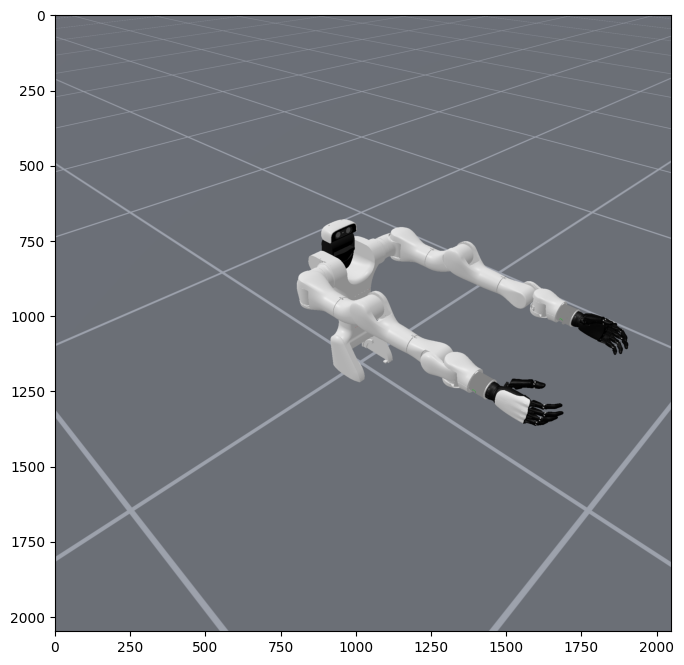

In [2]:
env = gym.make("Empty-v1", robot_uids="vega", render_mode="rgb_array")
env.action_space # shape (N, D)
env.observation_space # shape (N, ...)
env.reset()

# kf = env.agent.keyframes['rest']
# env.agent.robot.set_qpos(kf.qpos)
# env.agent.controller.reset()

plt.figure(figsize=(8, 8))
plt.imshow(env.render()[0].cpu().numpy())

In [19]:
# 检查关节顺序
from mani_skill.envs.scene import ManiSkillScene  
from mani_skill.utils.building import URDFLoader  
  
loader = URDFLoader()  
loader.set_scene(ManiSkillScene())  
robot = loader.load("/home/xzhan742/Coding/ManiSkill/vega_grasp/dexmate-urdf/robots/humanoid/vega_1/vega_upper_body_mod.urdf")  
# robot = loader.load("/home/xzhan742/Coding/ManiSkill/mani_skill/assets/robots/panda/panda_v2.urdf")  
import rich
rich.print(list(enumerate(robot.active_joints_map.keys())))
# print("\n".join(list(robot.active_joints_map.keys())))

2025-11-17 21:07:34,342 - mani_skill  - WARNING - No initial pose set for articulation builder of None, setting to default pose q=[1,0,0,0], p=[0,0,0]. There may be simulation issues/bugs if this articulation at it's initial pose collides with other objects at their initial poses.


[
    (0, 'head_j1'),
    (1, 'L_arm_j1'),
    (2, 'R_arm_j1'),
    (3, 'head_j2'),
    (4, 'L_arm_j2'),
    (5, 'R_arm_j2'),
    (6, 'head_j3'),
    (7, 'L_arm_j3'),
    (8, 'R_arm_j3'),
    (9, 'L_arm_j4'),
    (10, 'R_arm_j4'),
    (11, 'L_arm_j5'),
    (12, 'R_arm_j5'),
    (13, 'L_arm_j6'),
    (14, 'R_arm_j6'),
    (15, 'L_arm_j7'),
    (16, 'R_arm_j7'),
    (17, 'L_th_j0'),
    (18, 'L_ff_j1'),
    (19, 'L_mf_j1'),
    (20, 'L_rf_j1'),
    (21, 'L_lf_j1'),
    (22, 'R_th_j0'),
    (23, 'R_ff_j1'),
    (24, 'R_mf_j1'),
    (25, 'R_rf_j1'),
    (26, 'R_lf_j1'),
    (27, 'L_th_j1'),
    (28, 'L_ff_j2'),
    (29, 'L_mf_j2'),
    (30, 'L_rf_j2'),
    (31, 'L_lf_j2'),
    (32, 'R_th_j1'),
    (33, 'R_ff_j2'),
    (34, 'R_mf_j2'),
    (35, 'R_rf_j2'),
    (36, 'R_lf_j2'),
    (37, 'L_th_j2'),
    (38, 'R_th_j2')
]

In [3]:
env = gym.make("Empty-v1", robot_uids="vega",
                control_mode="pd_joint_delta_pos",
                render_mode="rgb_array")
# print(env.agent.robot.dof)
# print(env.agent.robot.active_joints)
# env.agent.robot.active_joints_map.keys()
# print(env.action_space)
# env.agent.controller
env.agent.robot.get_qvel().shape

/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


torch.Size([1, 39])

In [ ]:
env.reset()
obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
# obs (N, ...), rew (N, ), terminated (N, ), truncated (N, )
print(obs)
print(rew)
print(terminated)
print(truncated)
print(info)

In [ ]:
env = gym.make("Empty-v1", robot_uids="vega",
                control_mode="pd_joint_delta_pos",
                render_mode="rgb_array")
env = RecordEpisode(
    env,
    "./videos",
    max_steps_per_video=100
)

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)
env.agent.controller.reset()


for i in tqdm(range(200)):
    # action = np.ones(env.action_space.shape) * -0.1
    action = env.action_space.sample()
    action[:7] = 0
    # print(action)
    obs, reward, terminated, truncated, info = env.step(action)
    # print(obs)
env.close()

Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

## Sensor

In [8]:
env = gym.make("Empty-v1", robot_uids="vega", control_mode="pd_joint_delta_pos", obs_mode="rgb+depth+segmentation",
                render_mode="sensors")
# env.agent.robot.links_map['head_l3']
# env.agent.sensors.keys()
# env.print_sim_details()

env.agent._sensor_configs[3]

# obs, _ = env.reset()
# kf = env.agent.keyframes['rest']
# env.agent.robot.set_qpos(kf.qpos)

# plt.figure(figsize=(18, 8))
# plt.imshow(env.render()[0].cpu().numpy())

IndexError: list index out of range

In [9]:
# obs["sensor_data"].keys()
# obs["sensor_data"]["zed_left_camera"].keys()
env.agent.robot.links_map.keys()

2025-11-17 16:44:30,668 - mani_skill  - WARNING - Agent vega is already registered. Skip registration.


dict_keys(['torso_l3', 'arm_center', 'head_l1', 'L_arm_l1', 'R_arm_l1', 'head_l2', 'L_arm_l2', 'R_arm_l2', 'head_l3', 'L_arm_l3', 'R_arm_l3', 'zed_depth_frame', 'zed_left_camera', 'zed_right_camera', 'L_arm_l4', 'R_arm_l4', 'L_arm_l5', 'R_arm_l5', 'L_arm_l6', 'R_arm_l6', 'L_arm_l7', 'R_arm_l7', 'L_arm_l8', 'R_arm_l8', 'L_ee', 'L_hand_base', 'R_ee', 'R_hand_base', 'L_th_l0', 'L_ff_l1', 'L_mf_l1', 'L_rf_l1', 'L_lf_l1', 'R_th_l0', 'R_ff_l1', 'R_mf_l1', 'R_rf_l1', 'R_lf_l1', 'L_th_l1', 'L_ff_l2', 'L_mf_l2', 'L_rf_l2', 'L_lf_l2', 'R_th_l1', 'R_ff_l2', 'R_mf_l2', 'R_rf_l2', 'R_lf_l2', 'L_th_l2', 'L_ff_tip', 'L_mf_tip', 'L_rf_tip', 'L_lf_tip', 'R_th_l2', 'R_ff_tip', 'R_mf_tip', 'R_rf_tip', 'R_lf_tip', 'L_th_tip', 'R_th_tip'])

In [ ]:
obs, _ = env.reset()
# kf = env.agent.keyframes['rest']
# env.agent.robot.set_qpos(kf.qpos)
obs, reward, terminated, truncated, info = env.step(np.zeros(env.action_space.shape))

n_cams = len(obs['sensor_data'])
plt.figure(figsize=(15, 5*n_cams))
env_id = 0
for i, (key, cam) in enumerate(obs['sensor_data'].items()):
    rgb, depth = cam['rgb'], cam['depth']
    plt.subplot(n_cams,3,1+3*i)
    plt.title(f"{key} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(n_cams,3,2+3*i)
    plt.title(f"{key} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(n_cams,3,3+3*i)
    plt.title(f"{key} - Segmentation")
    plt.imshow(cam["segmentation"][..., 0][env_id].cpu().numpy())
plt.tight_layout()

In [ ]:
env = gym.make("Empty-v1", robot_uids="vega", control_mode="pd_joint_delta_pos",
                render_mode="sensors")
env = RecordEpisode(
    env,
    "./videos",
    max_steps_per_video=100
)

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
_k_qpos = kf.qpos.copy()
env.agent.robot.set_qpos(_k_qpos)
env.agent.controller.reset()


for i in tqdm(range(100)):
    _k_qpos[0] -= 0.01
    env.agent.robot.set_qpos(_k_qpos)
    # action = np.ones(env.action_space.shape) * -0.1
    action = env.action_space.sample()
    action[:7] = 0
    # print(action)
    obs, reward, terminated, truncated, info = env.step(action)
    # print(obs)
env.close()

Video("./videos/0.mp4", embed=True, width=1000) # Watch our replay

# Build Task

/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


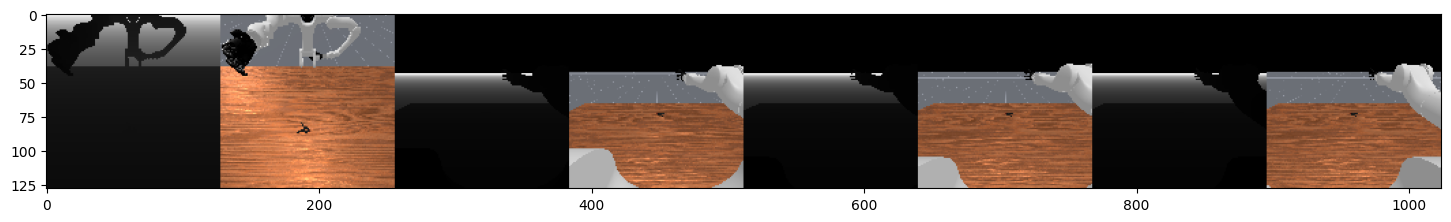

In [4]:
env = gym.make("MyPickSingleYCB-v1", robot_uids="vega", control_mode="pd_joint_delta_pos", obs_mode="rgb+depth",
                render_mode="sensors")

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)

plt.figure(figsize=(18, 8))
plt.imshow(env.render()[0].cpu().numpy())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


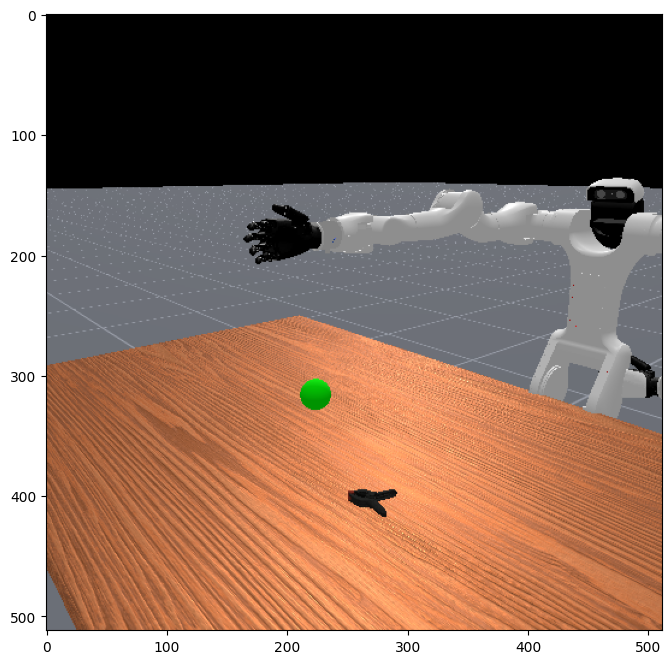

In [11]:
%load_ext autoreload
%autoreload 2
import torch
from tqdm import tqdm
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import Video

import sapien
import mani_skill.envs
from mani_skill.utils.wrappers import RecordEpisode

from vega_robot import Vega
from pick_single_ycb import PickSingleYCBEnv

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

env = gym.make("MyPickSingleYCB-v1", robot_uids="vega", control_mode="pd_joint_delta_pos", obs_mode="rgb+depth",
                render_mode="rgb_array")

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)

plt.figure(figsize=(18, 8))
plt.imshow(env.render()[0].cpu().numpy())